In [1]:
from sklearnex import patch_sklearn

patch_sklearn()

import pickle
import sys
sys.path.insert(0,'..')
import module as mod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer

from lightgbm import LGBMClassifier, Dataset, train, log_evaluation
import optuna

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Importation du jeu de données

In [2]:
house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [3]:
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [4]:
# we generate our features
windows = ['1h', '10min']
features_col = ['mains', 'hour']

house1_power_blk2, _ = mod.generate_features(house1_power_blk2, window=windows)
house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=windows)
features_col += cols

In [5]:
# train / test split
train_df_h1, testval_df_h1 = mod.train_test_split_dataset(house1_power_blk2, 0.5)
valid_df_h1, test_df_h1 = mod.train_test_split_dataset(testval_df_h1, 0.5)
X_train_h1, y_train_h1 = train_df_h1[features_col].values, train_df_h1["activity"].values
X_test_h1, y_test_h1 = test_df_h1[features_col].values, test_df_h1["activity"].values
X_valid_h1, y_valid_h1 = valid_df_h1[features_col].values, valid_df_h1["activity"].values

train_df_h2, testval_df_h2 = mod.train_test_split_dataset(house2_power_blk1, 0.5)
valid_df_h2, test_df_h2 = mod.train_test_split_dataset(testval_df_h2, 0.5)
X_train_h2, y_train_h2 = train_df_h2[features_col].values, train_df_h2["activity"].values
X_test_h2, y_test_h2 = test_df_h2[features_col].values, test_df_h2["activity"].values
X_valid_h2, y_valid_h2 = valid_df_h2[features_col].values, valid_df_h2["activity"].values

In [6]:
# mise à l'échelle des données
scaler = MinMaxScaler()
X_train_h1 = scaler.fit_transform(X_train_h1)
X_test_h1 = scaler.transform(X_test_h1)
X_valid_h1 = scaler.transform(X_valid_h1)

X_train_h2 = scaler.fit_transform(X_train_h2)
X_test_h2 = scaler.transform(X_test_h2)
X_valid_h2 = scaler.transform(X_valid_h2)

In [7]:
# on regroupe les données de la maison 1 + 2 et on shuffle
X_train_h12 = np.append(X_train_h1, X_train_h2, axis=0)
y_train_h12 = np.append(y_train_h1, y_train_h2, axis=0)
train_idx = np.random.choice(X_train_h12.shape[0],  int(0.5*X_train_h12.shape[0]), replace=False)
X_train_h12 = X_train_h12[train_idx, :]
y_train_h12 = y_train_h12[train_idx]

X_valid_h12 = np.append(X_valid_h1, X_valid_h2, axis=0)
y_valid_h12 = np.append(y_valid_h1, y_valid_h2, axis=0)
valid_idx = np.random.choice(X_valid_h12.shape[0], int(0.3*X_valid_h12.shape[0]), replace=False)
X_test_h12 = X_valid_h12[valid_idx, :]
y_test_h12 = y_valid_h12[valid_idx]

X_train_h12.shape, y_train_h12.shape

((2635200, 11), (2635200,))

# 2. Optimisation

In [17]:
# code with pruning
def objective(trial):
    dtrain = Dataset(X_train_h12, label=y_train_h12)
    dvalid = Dataset(X_valid_h12, label=y_valid_h12)

    param = {
        'verbosity': -1,
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Add a callback for pruning.
    #make_scorer(fbeta_score, beta=0.5)
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    gbm = train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback, log_evaluation(0)])

    y_preds = gbm.predict(X_valid_h12)
    y_labels = np.rint(y_preds)
    #accuracy = accuracy_score(y_valid_h12, y_labels)
    fb_score = fbeta_score(y_valid_h12, y_labels, beta=0.5)

    return fb_score

optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=60*60, show_progress_bar=True)

print(f'Finished {len(study.trials)} trials in {study.trials_dataframe(attrs=["duration"]).sum()[0]}')
print(f'Best trial: {study.best_value:.2%} with params: {study.best_trial.params}')

/home/pierre/.local/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
100%|██████████| 100/100 [08:17<00:00,  4.98s/it, 497.63/3600 seconds]

Finished 100 trials in 0 days 00:08:17.481408
Best trial: 86.14% with params: {'lambda_l1': 5.7697156354232726e-08, 'lambda_l2': 0.09393757061413283, 'num_leaves': 21, 'feature_fraction': 0.8562051606254208, 'bagging_fraction': 0.6693493351224262, 'bagging_freq': 7, 'min_child_samples': 33}


In [58]:
# code without pruning
def objective(trial):
    dtrain = Dataset(X_train_h12, label=y_train_h12)
    #dtest = Dataset(X_test_h12, label=y_test_h12)

    param = {
        'verbosity': -1,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Add a callback for pruning.
    #make_scorer(fbeta_score, beta=0.5)
    #pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_logloss')
    gbm = train(param, dtrain, callbacks=[log_evaluation(0)])

    y_preds = gbm.predict(X_valid_h12)
    y_labels = np.rint(y_preds)
    #accuracy = accuracy_score(y_valid_h12, y_labels)
    fb_score = fbeta_score(y_valid_h12, y_labels, beta=0.5)

    return fb_score

optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=60*60)

print(f'Finished {len(study.trials)} trials in {study.trials_dataframe(attrs=["duration"]).sum()[0]}')
print(f'Best trial: {study.best_value:.2%} with params: {study.best_trial.params}')

Finished 100 trials in 0 days 00:14:37.421627
Best trial: 86.63% with params: {'lambda_l1': 6.997872599114091e-08, 'lambda_l2': 3.106939695465658, 'num_leaves': 21, 'feature_fraction': 0.7749089992945499, 'bagging_fraction': 0.8304216244979004, 'bagging_freq': 4, 'min_child_samples': 92}


In [22]:
pickle.dump(study, open('optuna_study.pkl', 'wb'))

In [40]:
study.trials_dataframe(attrs=('number', 'value', 'duration', 'params', 'state')).sort_values(by='value', ascending=False).head()

,number,value,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,state
86,86,0.866324,0 days 00:00:07.097615,0.830422,4,0.774909,6.997873e-08,3.106940,92,21,COMPLETE
62,62,0.864377,0 days 00:00:06.868998,0.741750,3,0.929353,2.646206e-07,4.737462,95,22,COMPLETE
97,97,0.863938,0 days 00:00:06.745737,0.943587,6,0.796979,1.435894e-08,2.327462,99,13,COMPLETE
77,77,0.863890,0 days 00:00:06.943340,0.781318,3,0.748162,4.819023e-07,5.092320,88,21,COMPLETE
64,64,0.863708,0 days 00:00:06.911128,0.739346,3,0.880014,7.805053e-07,4.975168,90,22,COMPLETE


# Test de notre modèle

## Maison 1 vs 1

In [9]:
# re-entrainement du modèle sur la maison 1
#dtest_h1 = Dataset(X_test_h1, label=y_test_h1)
dtrain_h1 = Dataset(X_train_h1, label=y_train_h1)
best_params = {'lambda_l1': 6.997872599114091e-08,
              'lambda_l2': 3.106939695465658,
              'num_leaves': 21,
              'feature_fraction': 0.7749089992945499,
              'bagging_fraction': 0.8304216244979004,
              'bagging_freq': 4,
              'min_child_samples': 92
              }

gbm = train({**best_params, 'verbosity': -1}, dtrain_h1, callbacks=[log_evaluation(0)])

Score f_beta : 81.402%
Score accuracy : 81.559%
true positive rate: 96.23%, false positive rate: 13.21%


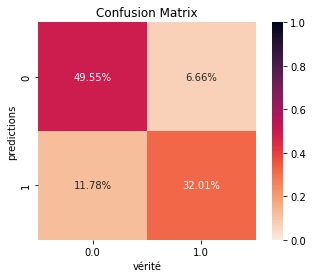

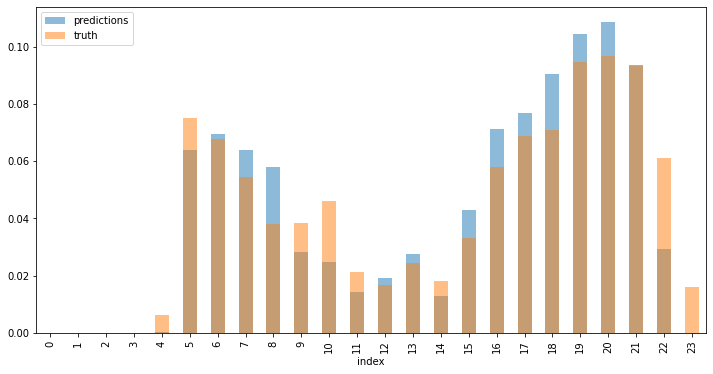

In [10]:
y_pred_h1 = gbm.predict(X_test_h1)
y_pred_h1 = np.rint(y_pred_h1)

mod.plot_confusion_matrix(y_test_h1, y_pred_h1);

house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res.iloc[-X_test_h1.shape[0]:, -1] = (y_pred_h1).astype(int)
activity_pred_h1 = house1_power_blk2_res['activity_pred'].iloc[-X_test_h1.shape[0]:]
activity_true_h1 = house1_power_blk2['activity'].iloc[-X_test_h1.shape[0]:]

fig, ax = plt.subplots()
mod.plot_activity_hist(activity_pred_h1, figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(activity_true_h1, figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

TPR, FPR = mod.score_overlap(activity_true_h1, activity_pred_h1)
print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

## Maison 1 vs 2

Score f_beta : 84.347%
Score accuracy : 84.558%
true positive rate: 77.36%, false positive rate: 7.55%


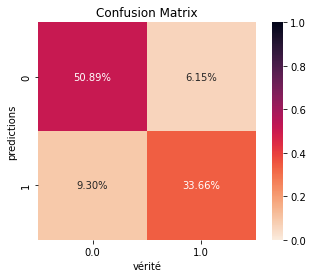

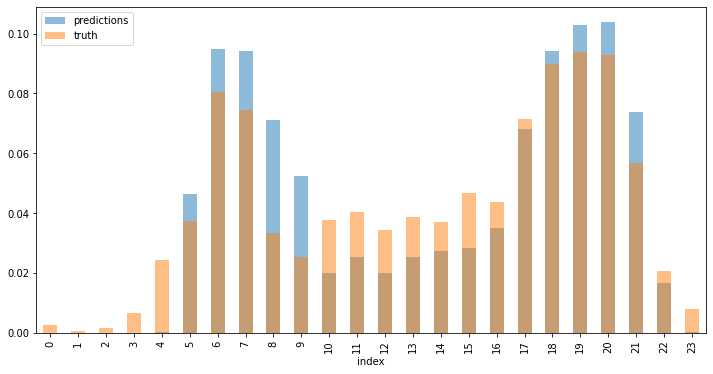

In [12]:
y_pred_h2 = gbm.predict(X_test_h2)
y_pred_h2 = np.rint(y_pred_h2)

mod.plot_confusion_matrix(y_test_h2, y_pred_h2);

house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res.iloc[-X_test_h2.shape[0]:, -1] = (y_pred_h2).astype(int)
activity_pred_h2 = house2_power_blk1_res['activity_pred'].iloc[-X_test_h2.shape[0]:]
activity_true_h2 = house2_power_blk1['activity'].iloc[-X_test_h2.shape[0]:]


fig, ax = plt.subplots()
mod.plot_activity_hist(activity_pred_h2, figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(activity_true_h2, figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

TPR, FPR = mod.score_overlap(activity_true_h2, activity_pred_h2)
print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

## Maison 2 vs 1

In [14]:
# re-entrainement du modèle sur la maison 1
dtrain_h2 = Dataset(X_train_h2, label=y_train_h2)
best_params = {'lambda_l1': 6.997872599114091e-08,
              'lambda_l2': 3.106939695465658,
              'num_leaves': 21,
              'feature_fraction': 0.7749089992945499,
              'bagging_fraction': 0.8304216244979004,
              'bagging_freq': 4,
              'min_child_samples': 92
              }

gbm = train({**best_params, 'verbosity': -1}, dtrain_h2, callbacks=[log_evaluation(0)])

Score f_beta : 79.284%
Score accuracy : 79.090%
true positive rate: 100.00%, false positive rate: 30.19%


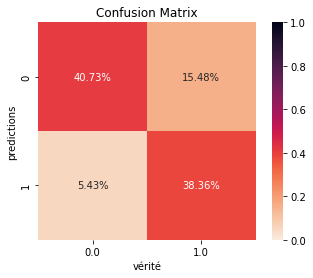

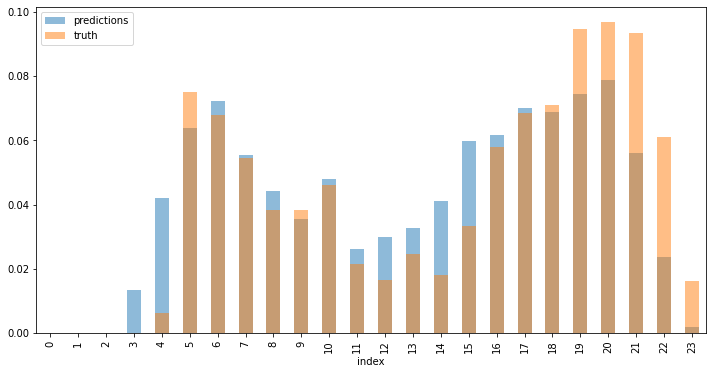

In [15]:
y_pred_h1 = gbm.predict(X_test_h1)
y_pred_h1 = np.rint(y_pred_h1)

mod.plot_confusion_matrix(y_test_h1, y_pred_h1);

house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res.iloc[-X_test_h1.shape[0]:, -1] = (y_pred_h1).astype(int)
activity_pred_h1 = house1_power_blk2_res['activity_pred'].iloc[-X_test_h1.shape[0]:]
activity_true_h1 = house1_power_blk2['activity'].iloc[-X_test_h1.shape[0]:]

fig, ax = plt.subplots()
mod.plot_activity_hist(activity_pred_h1, figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(activity_true_h1, figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

TPR, FPR = mod.score_overlap(activity_true_h1, activity_pred_h1)
print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

Score f_beta : 85.324%
Score accuracy : 85.447%
true positive rate: 92.45%, false positive rate: 13.21%


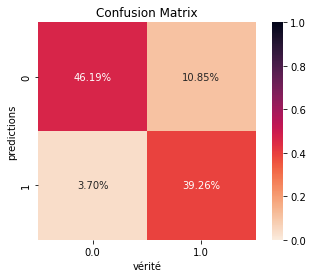

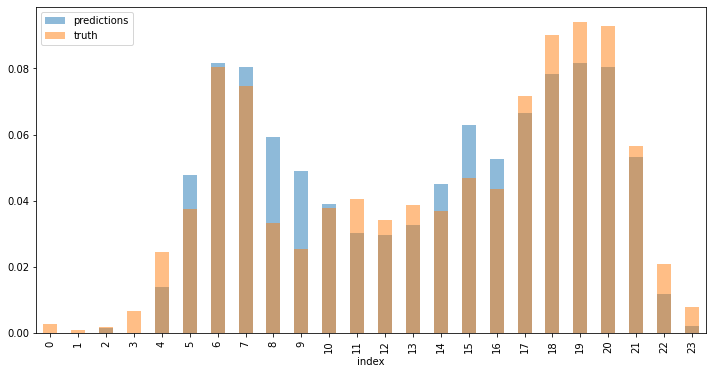

In [16]:
y_pred_h2 = gbm.predict(X_test_h2)
y_pred_h2 = np.rint(y_pred_h2)

mod.plot_confusion_matrix(y_test_h2, y_pred_h2);

house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res.iloc[-X_test_h2.shape[0]:, -1] = (y_pred_h2).astype(int)
activity_pred_h2 = house2_power_blk1_res['activity_pred'].iloc[-X_test_h2.shape[0]:]
activity_true_h2 = house2_power_blk1['activity'].iloc[-X_test_h2.shape[0]:]


fig, ax = plt.subplots()
mod.plot_activity_hist(activity_pred_h2, figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(activity_true_h2, figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

TPR, FPR = mod.score_overlap(activity_true_h2, activity_pred_h2)
print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

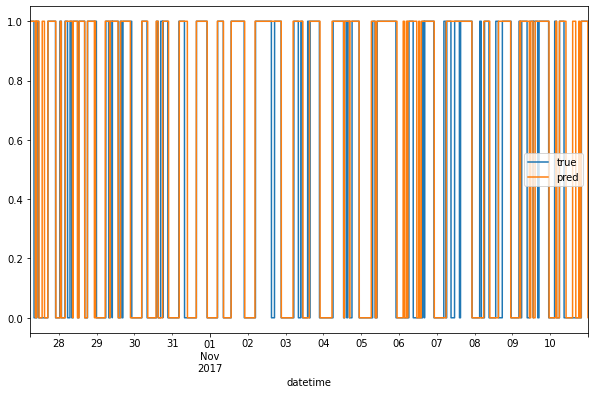

In [23]:
(activity_true_h2.rolling('30min').mean()>0).astype(int).plot(label='true', legend=True)
(activity_pred_h2.rolling('30min').mean()>0).astype(int).plot(figsize=(10, 6), label='pred', legend=True);